In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch import autograd
import torch.nn.functional as F
from torchvision.datasets import ImageFolder

from torchvision.utils import make_grid
from torch.utils.data import random_split
import os

import matplotlib.pyplot as plt

In [7]:
DATA_DIR = '../data/IMG'
TRAIN_DIR = DATA_DIR + "/training_set"
TEST_DIR = DATA_DIR + "/test_set"

In [8]:
classes = os.listdir(TRAIN_DIR)
print(classes)

['dogs', 'cats', '.DS_Store']


In [9]:
cats = os.listdir(TRAIN_DIR + "/cats")
print('No. of training examples for cats:', len(cats))
print(cats[:5])

No. of training examples for cats: 4000
['cat.3172.jpg', 'cat.293.jpg', 'cat.1890.jpg', 'cat.1667.jpg', 'cat.384.jpg']


In [10]:
dogs = os.listdir(TRAIN_DIR + "/dogs")
print('No. of training examples for dogs:', len(dogs))
print(dogs[:5])

No. of training examples for dogs: 4000
['dog.816.jpg', 'dog.2856.jpg', 'dog.3520.jpg', 'dog.2361.jpg', 'dog.3851.jpg']


In [12]:
from torchvision.datasets import ImageFolder

In [13]:
transform = transforms.Compose([transforms.Resize((100,100)),transforms.ToTensor()])
dataset = ImageFolder(DATA_DIR+'/training_set', transform=transform)


In [15]:
img, label = dataset[0]
print(img.shape, label)
img

torch.Size([3, 100, 100]) 0


tensor([[[0.1569, 0.1569, 0.1804,  ..., 0.4471, 0.7255, 0.7882],
         [0.1451, 0.1412, 0.1608,  ..., 0.4431, 0.7020, 0.7843],
         [0.1529, 0.1373, 0.1451,  ..., 0.4275, 0.7176, 0.8000],
         ...,
         [0.0824, 0.0784, 0.0863,  ..., 0.2902, 0.3098, 0.2549],
         [0.0941, 0.0824, 0.0863,  ..., 0.2510, 0.2118, 0.1804],
         [0.1098, 0.0863, 0.0941,  ..., 0.3098, 0.1843, 0.1804]],

        [[0.1765, 0.1725, 0.1922,  ..., 0.4588, 0.7176, 0.7765],
         [0.1647, 0.1529, 0.1725,  ..., 0.4549, 0.6902, 0.7608],
         [0.1725, 0.1490, 0.1569,  ..., 0.4392, 0.6980, 0.7647],
         ...,
         [0.0784, 0.0745, 0.0784,  ..., 0.2235, 0.2510, 0.2039],
         [0.0863, 0.0745, 0.0784,  ..., 0.1843, 0.1569, 0.1333],
         [0.1020, 0.0784, 0.0863,  ..., 0.2431, 0.1294, 0.1333]],

        [[0.1647, 0.1804, 0.2157,  ..., 0.4667, 0.6392, 0.6471],
         [0.1529, 0.1647, 0.1961,  ..., 0.4745, 0.6235, 0.6471],
         [0.1608, 0.1608, 0.1804,  ..., 0.4627, 0.6431, 0.

In [16]:
print(dataset.classes)

['cats', 'dogs']


In [17]:
import matplotlib.pyplot as plt

def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  cats (0)


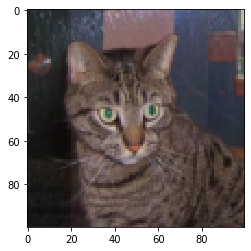

In [18]:
show_example(*dataset[0])

Label:  dogs (1)


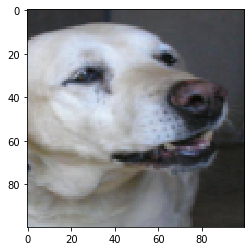

In [19]:
show_example(*dataset[4800])

In [20]:
random_seed = 42
torch.manual_seed(random_seed);

In [21]:
len(dataset)

8000

In [22]:
val_size = 2000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(6000, 2000)

In [24]:
batch_size=64
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

In [25]:
def show_batch(dl, invert=False):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        data = 1-images if invert else images
        ax.imshow(make_grid(data, nrow=16).permute(1, 2, 0))
        break

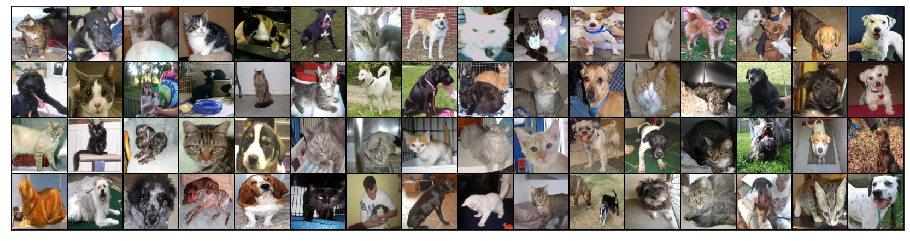

In [26]:
show_batch(train_loader)

In [27]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [28]:
class ImageClassificationModelBase(nn.Module):
    def training_step(self, batch):
        images, targets = batch 
        out = self(images)                      
        loss = F.cross_entropy(out, targets)      
        return loss
    
    def validation_step(self, batch):
        images, targets = batch 
        out = self(images)                           # Generate predictions
        loss = F.cross_entropy(out, targets)  # Calculate loss
        acc = accuracy(out, targets)
        return {'val_loss': loss.detach(), 'val_acc': acc }
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_acc = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_acc).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch,result['train_loss'], result['val_loss'], result['val_acc']))

In [29]:
class ImageClassificationModel(ImageClassificationModelBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), #output 32 X 100 X 100 | (Receptive Field (RF) -  3 X 3
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),   #output 64 X 100 X 100 | RF 5 X 5
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 50 x 50 | RF 10 X 10

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # output: 64 x 50 x 50 | RF 12 X 12
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 25 x 25  | RF 24 X 24
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # output: 256 x 25 x 25  | RF 26 X 26
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 12 x 12 | RF 52 X 52
            
            nn.Conv2d(256, 512, kernel_size=3, stride=1), #512* 10* 10 | RF 54 X 54
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 512 x 5 x 5 | RF - 108X 108
            

            nn.Flatten(),
            nn.Linear(512 * 5 * 5,10))
         
    def forward(self, xb):
        return self.network(xb)

In [30]:
#function to ensure that our code uses the GPU if available, and defaults to using the CPU if it isn't.
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
# a function that can move data and model to a chosen device.    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


#Finally, we define a DeviceDataLoader class to wrap our existing data loaders and move data to the selected device, 
#as a batches are accessed. Interestingly, we don't need to extend an existing class to create a PyTorch dataloader. 
#All we need is an __iter__ method to retrieve batches of data, and an __len__ method to get the number of batches.

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [31]:
device = get_default_device()
device

device(type='cpu')

In [32]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [33]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [34]:
model = to_device(ImageClassificationModel(), device)

In [35]:
!pip install torchsummary

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.


In [36]:
from torchsummary import summary
# print the summary of the model
summary(model, input_size=(3, 100, 100), batch_size=-1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 100, 100]             896
              ReLU-2         [-1, 32, 100, 100]               0
            Conv2d-3         [-1, 64, 100, 100]          18,496
              ReLU-4         [-1, 64, 100, 100]               0
         MaxPool2d-5           [-1, 64, 50, 50]               0
            Conv2d-6          [-1, 128, 50, 50]          73,856
              ReLU-7          [-1, 128, 50, 50]               0
         MaxPool2d-8          [-1, 128, 25, 25]               0
            Conv2d-9          [-1, 256, 25, 25]         295,168
             ReLU-10          [-1, 256, 25, 25]               0
        MaxPool2d-11          [-1, 256, 12, 12]               0
           Conv2d-12          [-1, 512, 10, 10]       1,180,160
             ReLU-13          [-1, 512, 10, 10]               0
        MaxPool2d-14            [-1, 51

In [37]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.3109853267669678, 'val_acc': 0.0}]

In [38]:
num_epochs = 20
opt_func = torch.optim.Adam
lr = 0.001
history = fit(num_epochs, lr, model, train_loader, val_loader, opt_func)

OSError: [Errno 12] Cannot allocate memory